# ECE 271A HW \#1 The Cheetah Problem

The first step is to load the traning data with .mat format. For Pyhton I use package scipy.io.loadmat.

In [1]:
#import data
import numpy as np
from scipy.io import loadmat
m = loadmat('homework1/TrainingSamplesDCT_8.mat')

In [2]:
m

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Tue Sep 30 09:32:20 2003',
 '__version__': '1.0',
 '__globals__': [],
 'TrainsampleDCT_FG': array([[1.62254902e+00, 4.38433862e-01, 1.99470128e-01, ...,
         8.49984789e-03, 3.78270042e-03, 3.02880400e-03],
        [1.56372549e+00, 8.21143328e-02, 9.09413795e-02, ...,
         3.18521582e-03, 5.81148077e-03, 8.88559648e-03],
        [1.24607843e+00, 1.06458077e-01, 4.86748243e-02, ...,
         1.98793183e-03, 2.02433826e-03, 2.26600748e-03],
        ...,
        [8.50000000e-01, 2.13586353e-02, 2.73332331e-02, ...,
         5.28559315e-03, 5.74533250e-04, 1.30883711e-03],
        [1.32696078e+00, 1.27736043e-02, 7.25986937e-02, ...,
         2.48390433e-03, 5.72821344e-03, 6.14234163e-04],
        [1.40637255e+00, 5.37446031e-02, 3.52432448e-02, ...,
         1.16665737e-02, 7.05600416e-04, 6.92833289e-04]]),
 'TrainsampleDCT_BG': array([[2.79215686e+00, 1.82403883e-01, 8.22381982e-02, ...,
         8.99171356e-04,

The .mat file is loaded as a dictionary in Python;<br/>For this problem, we will simply extract TrainsampleDCT_FG and TrainsampleDCT_BG out from the dictionary.

In [3]:
foreground,background = m['TrainsampleDCT_FG'],m['TrainsampleDCT_BG']

Calculate the prior probability for cheetah(foreground) and grass(background);<br/>
Here the reasonable estimate for the prior is to use total number of training samples to devide the number of training samples of the foreground or background.

In [4]:
total = foreground.shape[0] + background.shape[0]
prior_cheetah = foreground.shape[0] / total
prior_grass = background.shape[0] / total
print(prior_cheetah)
print(prior_grass)

0.1918649270913277
0.8081350729086723


In [5]:
#initialization
freq_FG,freq_BG = np.zeros(64),np.zeros(64)
FG,BG = [],[]

For each foreground and background training sample, find the index of the second largest coefficient. Store the coefficient in 'FG' and 'BG' and add 1 to specific index of the foreground and background frequency map.

In [6]:
for i in range(len(foreground)):
    temp = np.argsort(foreground[i])
    freq_FG[temp[-2]] += 1
    FG.append(temp[-2])

In [7]:
for i in range(len(background)):
    temp = np.argsort(background[i])
    freq_BG[temp[-2]] += 1
    BG.append(temp[-2])

In [8]:
FG = np.array(FG)
BG = np.array(BG)

Histogram

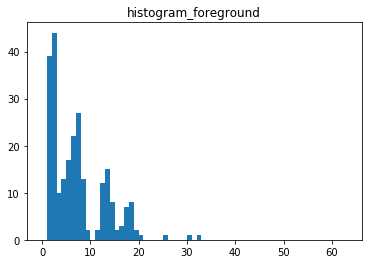

In [10]:
from matplotlib import pyplot as plt
plt.hist(FG, bins =  [i for i in range(64)]) 
plt.title("histogram_foreground") 
plt.show()

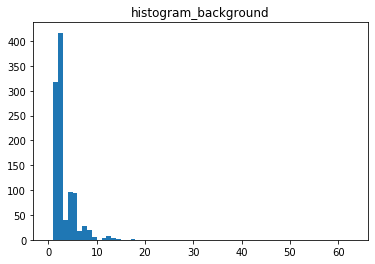

In [11]:
plt.hist(BG, bins =  [i for i in range(64)]) 
plt.title("histogram_background") 
plt.show()

Convert frequency to probability.

In [12]:
prob_FG = freq_FG / len(foreground)
prob_BG = freq_BG / len(background)

In [13]:
import imageio
im = imageio.imread('homework1/cheetah.bmp')
im_array = np.array(im)

Define a 2 dimensional DCT function using the 1 dimensional DCT function provided by scipy.

In [14]:
import scipy.fftpack
def dct2d(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

In [15]:
zig_zag = np.array([[0,1,5,6,14,15,27,28],[2,4,7,13,16,26,29,42],[3,8,12,17,25,30,41,43],
                   [9,11,18,24,31,40,44,53],[10,19,23,32,39,45,52,54],[20,22,33,38,46,51,55,60],
                   [21,34,37,47,50,56,59,61],[35,36,48,49,57,58,62,63]])
zz_flat = zig_zag.flatten()
print(zz_flat)

[ 0  1  5  6 14 15 27 28  2  4  7 13 16 26 29 42  3  8 12 17 25 30 41 43
  9 11 18 24 31 40 44 53 10 19 23 32 39 45 52 54 20 22 33 38 46 51 55 60
 21 34 37 47 50 56 59 61 35 36 48 49 57 58 62 63]


Convert the (255,270) matrix to blocks of size (8,8), calculate the DCT of each block and get the index of the second largest coefficient (using zig-zag map);<br/>
For each block, calcuate probability that this block is whether a foreground or a background using BDT. Then label the block with the state that has a higher probability and store the state of each block in A.

In [16]:
A = []
for i in range(0,len(im_array)-8):
    for j in range(0,im_array.shape[1]-8):
        row_start,row_end = i,i+8
        col_start,col_end = j,j+8
        block = im_array[row_start:row_end,col_start:col_end]
        block_dct = dct2d(block).flatten()
        index = np.argsort(block_dct)[-2]
        if prior_cheetah * prob_FG[zz_flat[index]] >= prior_grass * prob_BG[zz_flat[index]]:
            A.append(1)
        else:
            A.append(0)
A = np.array(A)
print(A)

[0 0 1 ... 0 0 1]


In [17]:
A_matrix = np.reshape(A,(247,262))

Right now the size of the matrix(picture) is (247,262), we need to do some paddings around the picture so as to maintain the size of the picture, which is (255,270).

In [18]:
A_matrix_padding = np.lib.pad(A_matrix,(4,4),'constant',constant_values = 0)

In [19]:
A_matrix_padding.shape

(255, 270)

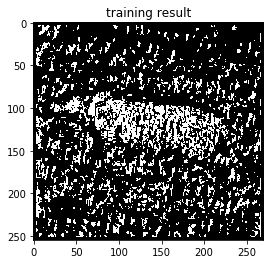

In [20]:
import matplotlib.pyplot as plt
plt.imshow(A_matrix_padding,cmap='gray')
plt.title("training result")
plt.show()

In [21]:
# store the test data as a numpy array
im_test = imageio.imread('homework1/cheetah_mask.bmp')
im_test_array = np.array(im_test)
# convert 255 to 1 for error calculation
im_test_array = im_test_array / 255

In [22]:
a = np.absolute(im_test_array - A_matrix_padding)

In [23]:
prob_error = np.sum(a) / (255 * 270)

In [24]:
prob_error

0.24422657952069718